# Image Classification Data Pipeline Setup

# ⚠️ **Suppressing Warnings in Python**

In [1]:
import warnings  # Import the warnings module

# Ignore all warning messages to keep the output clean
warnings.filterwarnings('ignore')

# 📂 Defining Dataset Paths

In [2]:
# 1. Define the directory paths for the training and testing datasets
train_dir = './xray_dataset_covid19/train/'  # Path to the training dataset
test_dir = './xray_dataset_covid19/test/'    # Path to the testing dataset

# Print directory paths to confirm
print(f"Training Directory: {train_dir}")
print(f"Testing Directory: {test_dir}")

Training Directory: ./xray_dataset_covid19/train/
Testing Directory: ./xray_dataset_covid19/test/


# 🖼️ Image Data Augmentation

In [3]:
# 2. Import ImageDataGenerator for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance for the training set with specified transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values from [0, 255] to [0, 1] (normalization)
    shear_range=0.2,        # Apply random shearing transformations
    zoom_range=0.2,         # Apply random zoom transformations
    horizontal_flip=True    # Randomly flip the images horizontally
)


# 🖼️ Creating Validation Data Generator

In [4]:
# 3. Create an ImageDataGenerator instance for the validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255  # Rescale pixel values for normalization (from [0, 255] to [0, 1])
)


# 📊 Creating Training Data Generator

In [5]:
# 4. Create a data generator for the training set using the ImageDataGenerator instance
train_generator = train_datagen.flow_from_directory(
    train_dir,               # Path to the training data directory
    target_size=(224, 224),  # Resize all images to 224x224 pixels
    batch_size=1,           # Number of images to be yielded from the generator per batch
    class_mode='binary'      # Specify binary classification (e.g., COVID-19 vs. Normal)
)


Found 148 images belonging to 2 classes.


# 🔄 Creating Testing Data Generator

In [6]:
# 5. Create a data generator for the testing/validation set using the ImageDataGenerator instance
test_generator = validation_datagen.flow_from_directory(
    test_dir,                # Path to the testing/validation data directory
    target_size=(224, 224),  # Resize all images to 224x224 pixels
    batch_size=1,            # Number of images to be yielded from the generator per batch
    class_mode='binary',     # Specify binary classification (e.g., COVID-19 vs. Normal)
    shuffle=False            # Disable shuffling
)



Found 40 images belonging to 2 classes.


# 📷 Displaying Images

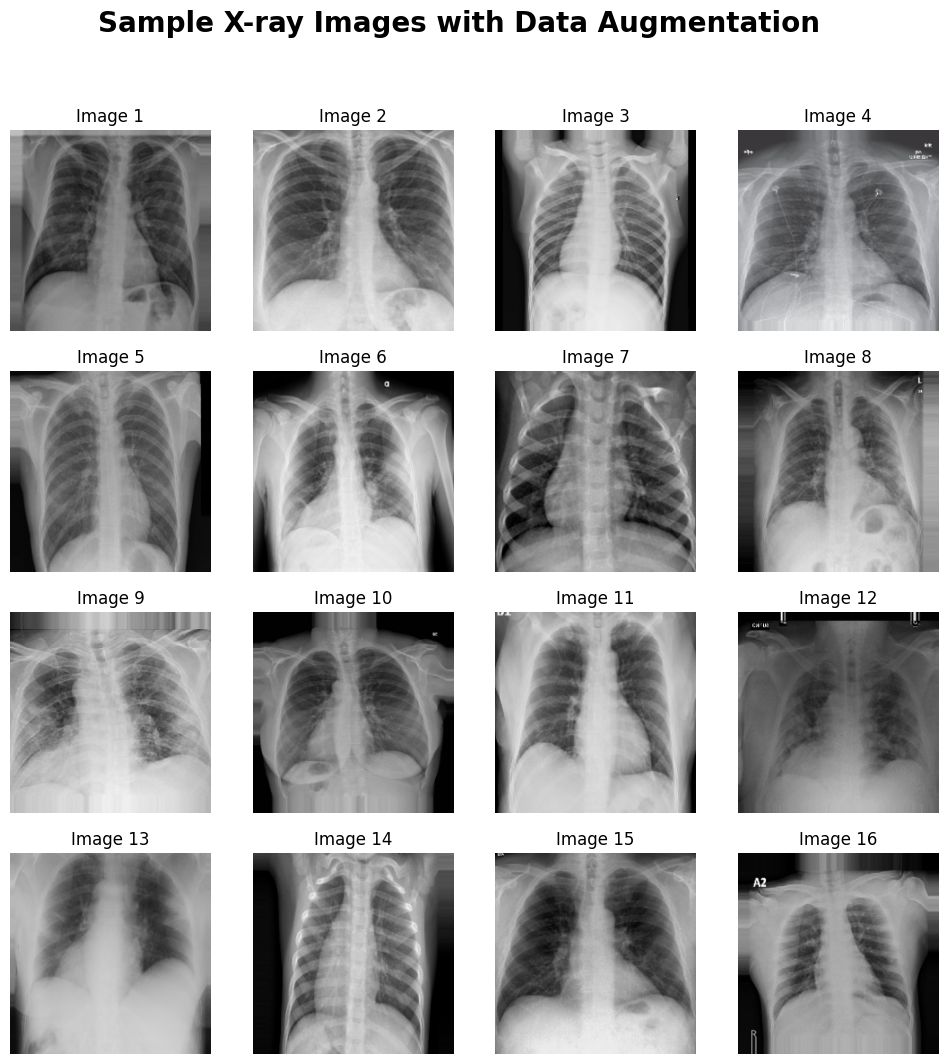

In [7]:
import numpy as np  # NumPy library: Supports numerical operations and works with arrays.
import matplotlib.pyplot as plt  # Matplotlib library: Used for creating graphs and visualizations.

# Function to display augmented images with numbering
def display_augmented_images(generator, num_images=16):
    plt.figure(figsize=(12, 12))  # Create a new display window with size 12x12 inches.
    
    for i in range(num_images):
        img, _ = next(generator)  # Retrieve a new image from the generator (ignore labels).
        plt.subplot(4, 4, i + 1)  # Create a grid of 4 rows and 4 columns to display images.
        plt.imshow(img[0])  # Display the first image from the batch.
        plt.axis('off')  # Hide the axes.
        
        # Add numbering to each image
        plt.title(f'Image {i + 1}', fontsize=12)  # Add a title for each image.

    plt.suptitle("Sample X-ray Images with Data Augmentation",
                 fontsize=20,
                 fontweight='bold')  # Add a main title for the display.
    
    # Save the figure with high resolution
    plt.savefig('augmented_images_with_numbers.png',
                dpi=300,
                bbox_inches='tight')  # Save the figure as a PNG file with high resolution.
    plt.show()  # Display the figure in a window.

# Display 16 sample images with numbering
display_augmented_images(train_generator, num_images=16)  # Display 16 images with numbering.


# 🛠️ Compiling the Model

In [8]:
from tensorflow.keras.optimizers import Adam

# 6. Import the optimizers module from TensorFlow Keras
from tensorflow.keras import optimizers

# Define a function to compile the model
def compile_model(model):
    
    # Compile the model with the given parameters
    model.compile(
        optimizer=optimizers.Adam(    # Use Adam optimizer for training
            learning_rate=0.0001),     # Set the learning rate to 0.0001
        loss='binary_crossentropy',    # Use binary cross-entropy loss for binary classification
        metrics=['accuracy']           # Track accuracy during training and testing
    )

    # Print a message to confirm successful compilation
    print("Model compiled successfully.")

# R

In [9]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True,  
    verbose=1              
)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.1,     # 0.1     
    patience=5,     # 5     
    verbose=1
)

# 🏋️ Training the Model

In [11]:
import pandas as pd
from tabulate import tabulate

# 7. Define a function for training the model
def train_model(model):
    # Train the model using the training data generator and validate using the testing data generator
    history = model.fit(
        train_generator,         # Training data generator
        epochs=100,                # Number of training epochs (iterations over the dataset)
        validation_data=test_generator,  # Testing data generator for validation
        callbacks=[early_stopping, reduce_lr]
    )

    # Convert the results into a DataFrame for formatted display
    history_df = pd.DataFrame(history.history)
    
    # Round values to two decimal places
    history_df = history_df.round(2)

    # Display the results in a professional table format
    print(tabulate(history_df, headers='keys', tablefmt='fancy_grid', showindex=True))

    return history  # Return the training history


# 🏗️ Creating the Model

In [12]:
# 8. Import the required modules from TensorFlow Keras
from tensorflow.keras import models  # Import 'models' module for building neural network models

def create_and_summarize_model(inputs, outputs):
    # inputs: Input layer(s) defining the shape and type of input data
    # outputs: Output layer(s) defining the structure of the model's predictions
    
    # Step 1: Create the complete model by specifying the inputs and outputs
    model = models.Model(
        inputs=inputs,   # 'inputs': TensorFlow Keras Input object or list of Input objects
        outputs=outputs  # 'outputs': TensorFlow Keras Layer object or list of Layer objects
    )

    # Step 2: Display the model summary
    model.summary()  # Print a summary of the model architecture and parameters
    
    return model  # Return the created model


# 🧮 Evaluating Model Performance

## 📏 Evaluating Model Metrics

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the model based on true and predicted labels
def evaluate_model(true_labels, predicted_labels):
    """
    Evaluate the model based on Accuracy, Precision, Recall, and F1 Score.
    """
    accuracy = accuracy_score(
        true_labels,                # true_labels: The ground truth labels (actual values)
        predicted_labels            # predicted_labels: The labels predicted by the model
    )  # Accuracy: (TP + TN) / (TP + TN + FP + FN)

    precision = precision_score(
        true_labels,                # true_labels: The ground truth labels (actual values)
        predicted_labels,           # predicted_labels: The labels predicted by the model
        average='binary'            # average: Determines the type of averaging performed on the data. 'binary' for binary classification
    )  # Precision: TP / (TP + FP)

    recall = recall_score(
        true_labels,                # true_labels: The ground truth labels (actual values)
        predicted_labels,           # predicted_labels: The labels predicted by the model
        average='binary'            # average: Determines the type of averaging performed on the data. 'binary' for binary classification
    )  # Recall: TP / (TP + FN)

    f1 = f1_score(
        true_labels,                # true_labels: The ground truth labels (actual values)
        predicted_labels,           # predicted_labels: The labels predicted by the model
        average='binary'            # average: Determines the type of averaging performed on the data. 'binary' for binary classification
    )  # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)

    evaluation_results = {
        "Accuracy": accuracy,          # accuracy: Overall accuracy of the model
        "Precision": precision,        # precision: The ability of the model to classify positive samples correctly
        "Recall": recall,              # recall: The ability of the model to find all positive samples
        "F1 Score": f1                 # f1: Harmonic mean of precision and recall
    }

    return evaluation_results


## 📝 Evaluating Test Data Summary

In [14]:
import pandas as pd
from tabulate import tabulate

def evaluate_test_data(model, test_generator):

    # Retrieve the true labels from the test data generator
    true_labels = test_generator.classes  # Get true labels directly from the data generator

    # Use the model to generate predictions
    predicted_labels = model.predict(test_generator)  # Generate predictions for test data

    # Convert the predictions to binary format (1 for positive, 0 for negative)
    predicted_labels = [1 if pred > 0.5 else 0 for pred in predicted_labels]  # Convert probabilities to binary labels

    # Calculate the number of correct and incorrect predictions
    correct = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred])  # Count correct predictions
    incorrect = len(true_labels) - correct  # Calculate incorrect predictions

    # Create a summary dictionary to store the results
    summary = {
        'Metric': ['Total Samples', 'Correct Predictions', 'Incorrect Predictions', 'Accuracy (%)'],  # Define metric labels
        'Value': [len(true_labels), correct, incorrect, round(correct / len(true_labels) * 100, 2)]   # Define values for each metric
    }

    # Convert the summary dictionary into a DataFrame
    summary_df = pd.DataFrame(summary)  # Create DataFrame to structure the results

    # Print the table using tabulate for a clear visualization
    table = tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False)  # Format table for printing
    print(table)  # Output the table

# No DataFrame is returned; the function is used to print the summary only


# 📈 Visualizing Training Results

In [15]:
# 9. Import the necessary library for plotting
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for visualizing the results

# Function to plot training history with adjusted figure size
def plot_training_history(history):
    # Extract accuracy and loss values from the training history
    acc = history.history['accuracy']            # Training accuracy values
    val_acc = history.history['val_accuracy']     # Validation accuracy values
    loss = history.history['loss']                # Training loss values
    val_loss = history.history['val_loss']        # Validation loss values
    epochs_range = range(len(acc))                # Generate range for the number of epochs (x-axis)

    # Adjusted figure size to be wider for better readability
    plt.figure(figsize=(18, 6))  # Set figure size to be 18 inches wide and 6 inches tall

    # Training and Validation Loss Plot
    plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and select the 1st plot
    plt.plot(
        epochs_range,     # x-axis values for each epoch
        loss,             # y-axis values for training loss
        'b-',             # Blue solid line style for training loss
        marker='o',       # Circle marker for each epoch point
        label='Training Loss',  # Label for the training loss curve
        linewidth=2       # Line thickness set to 2
    )
    plt.plot(
        epochs_range,     # x-axis values for each epoch
        val_loss,         # y-axis values for validation loss
        'r--',            # Red dashed line style for validation loss
        marker='x',       # Cross marker for each epoch point
        label='Validation Loss',  # Label for the validation loss curve
        linewidth=2       # Line thickness set to 2
    )
    plt.xlabel('Epochs')  # Set the label for the x-axis as 'Epochs'
    plt.ylabel('Loss')    # Set the label for the y-axis as 'Loss'
    plt.title('Model Loss Over Epochs')  # Set the title for the loss plot
    plt.legend()  # Display the legend for the curves
    plt.grid(True)  # Enable grid for better readability

    # Annotate the minimum validation loss
    min_val_loss = min(val_loss)  # Get the minimum value of validation loss
    min_val_loss_epoch = val_loss.index(min_val_loss)  # Get the epoch index of the minimum validation loss
    plt.annotate(
        f'Min Val Loss: {min_val_loss:.4f}',  # Text to display the minimum validation loss
        xy=(min_val_loss_epoch, min_val_loss),  # Set the (x, y) position of the minimum point
        xytext=(min_val_loss_epoch + 0.1, min_val_loss + 0.02),  # Position of the annotation text
        arrowprops=dict(
            facecolor='black',  # Set arrow color to black
            shrink=0.05,        # Shrink factor for the arrow tail
            width=0.5,          # Set arrow width
            headwidth=5,        # Set arrow head width
            headlength=5        # Set arrow head length
        ),
        fontsize=12,           # Set font size of the annotation text
        color='black'          # Set text color to black
    )

    # Training and Validation Accuracy Plot
    plt.subplot(1, 2, 2)  # Create a subplot with 1 row, 2 columns, and select the 2nd plot
    plt.plot(
        epochs_range,     # x-axis values for each epoch
        acc,              # y-axis values for training accuracy
        'g-',             # Green solid line style for training accuracy
        marker='s',       # Square marker for each epoch point
        label='Training Accuracy',  # Label for the training accuracy curve
        linewidth=2       # Line thickness set to 2
    )
    plt.plot(
        epochs_range,     # x-axis values for each epoch
        val_acc,          # y-axis values for validation accuracy
        'y--',            # Yellow dashed line style for validation accuracy
        marker='^',       # Triangle-up marker for each epoch point
        label='Validation Accuracy',  # Label for the validation accuracy curve
        linewidth=2       # Line thickness set to 2
    )
    plt.xlabel('Epochs')  # Set the label for the x-axis as 'Epochs'
    plt.ylabel('Accuracy')  # Set the label for the y-axis as 'Accuracy'
    plt.title('Model Accuracy Over Epochs')  # Set the title for the accuracy plot
    plt.legend()  # Display the legend for the curves
    plt.grid(True)  # Enable grid for better readability

    # Annotate the maximum validation accuracy
    max_val_acc = max(val_acc)  # Get the maximum value of validation accuracy
    max_val_acc_epoch = val_acc.index(max_val_acc)  # Get the epoch index of the maximum validation accuracy
    plt.annotate(
        f'Max Val Accuracy: {max_val_acc:.4f}',  # Text to display the maximum validation accuracy
        xy=(max_val_acc_epoch, max_val_acc),  # Set the (x, y) position of the maximum point
        xytext=(max_val_acc_epoch + 0.1, max_val_acc - 0.02),  # Position of the annotation text
        arrowprops=dict(
            facecolor='black',  # Set arrow color to black
            shrink=0.05,        # Shrink factor for the arrow tail
            width=0.5,          # Set arrow width
            headwidth=5,        # Set arrow head width
            headlength=5        # Set arrow head length
        ),
        fontsize=12,           # Set font size of the annotation text
        color='black'          # Set text color to black
    )

    # Add an overall title and show the plot
    plt.suptitle(f'Final Validation Accuracy: {max_val_acc:.4f} | Final Validation Loss: {min_val_loss:.4f}', fontsize=16)  # Add a super title for both subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap (rect defines the positioning)
    plt.show()  # Display the plot


# Model and Training 

# 5. 🧱 Building - ResNet50

In [16]:
from tensorflow.keras.applications import ResNet50  # Import the ResNet50 architecture for transfer learning

# # Step 1: Load the base model (ResNet50) with pre-trained weights
base_model = ResNet50(
    weights='imagenet',         # Use pre-trained weights from the 'imagenet' dataset
    include_top=False,          # Exclude the top (classification) layer of ResNet50
    input_shape=(224, 224, 3)   # Input shape: images with 224x224 resolution and 3 color channels (RGB)
)
print("Model loaded successfully!")


Model loaded successfully!


In [17]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout  # Import specific layers for the custom model

# Step 2: Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False  # Set all layers to non-trainable to keep pre-trained weights unchanged

# Step 3: Define the input layer
inputs = Input(shape=(224, 224, 3))  # Define the input shape: 224x224 pixels and 3 channels (RGB)

# Step 4: Pass the inputs through the base model
x = base_model(inputs)  # Pass the defined input layer through the base model

# Step 5: Add custom layers on top of the base model
x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling to reduce spatial dimensions
x = Dense(512, activation='relu')(x)  # Add a Dense layer with 512 units and ReLU activation

# Step 6: Apply Dropout for regularization
x = Dropout(0.5)(x)  # Apply a Dropout layer with a 50% rate to reduce overfitting

# Step 7: Define the output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)  # Output layer with a single unit and sigmoid activation

# Create and summarize the model using the defined function
model = create_and_summarize_model(inputs=inputs, outputs=outputs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## ⚙️ Compiling the Model - ResNet50

In [18]:
# Compile the model using the defined function
compile_model(model)

Model compiled successfully.


## 🏋️ Training the Model - ResNet50

In [19]:
# Call the function to train the model
history = train_model(model)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 187s 673ms/step - accuracy: 0.5281 - loss: 0.8076 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 1.0000e-04
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 77s 514ms/step - accuracy: 0.4021 - loss: 0.8710 - val_accuracy: 0.5000 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 76s 503ms/step - accuracy: 0.4977 - loss: 0.7591 - val_accuracy: 0.5000 - val_loss: 0.6340 - learning_rate: 1.0000e-04
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 83s 541ms/step - accuracy: 0.5557 - loss: 0.7074 - val_accuracy: 0.9250 - val_loss: 0.6125 - learning_rate: 1.0000e-04
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 81s 522ms/step - accuracy: 0.5125 - loss: 0.7299 - val_accuracy: 0.9250 - val_loss: 0.5991 - learning_rate: 1.0000e-04
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 78s 506ms/step - accuracy: 0.5864 - loss: 0.7065 - val_accuracy: 0.9500 - val_loss: 0.5860 - learning_rate: 1.0000e-04
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━

## 🧪 Evaluating Test Data - ResNet50

In [20]:
# Evaluate the model using the provided test data generator
evaluate_test_data(model, test_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 276ms/step
╒═══════════════════════╤═════════╕
│ Metric                │   Value │
╞═══════════════════════╪═════════╡
│ Total Samples         │    40   │
├───────────────────────┼─────────┤
│ Correct Predictions   │    39   │
├───────────────────────┼─────────┤
│ Incorrect Predictions │     1   │
├───────────────────────┼─────────┤
│ Accuracy (%)          │    97.5 │
╘═══════════════════════╧═════════╛


## 📈 Training Plan - ResNet50

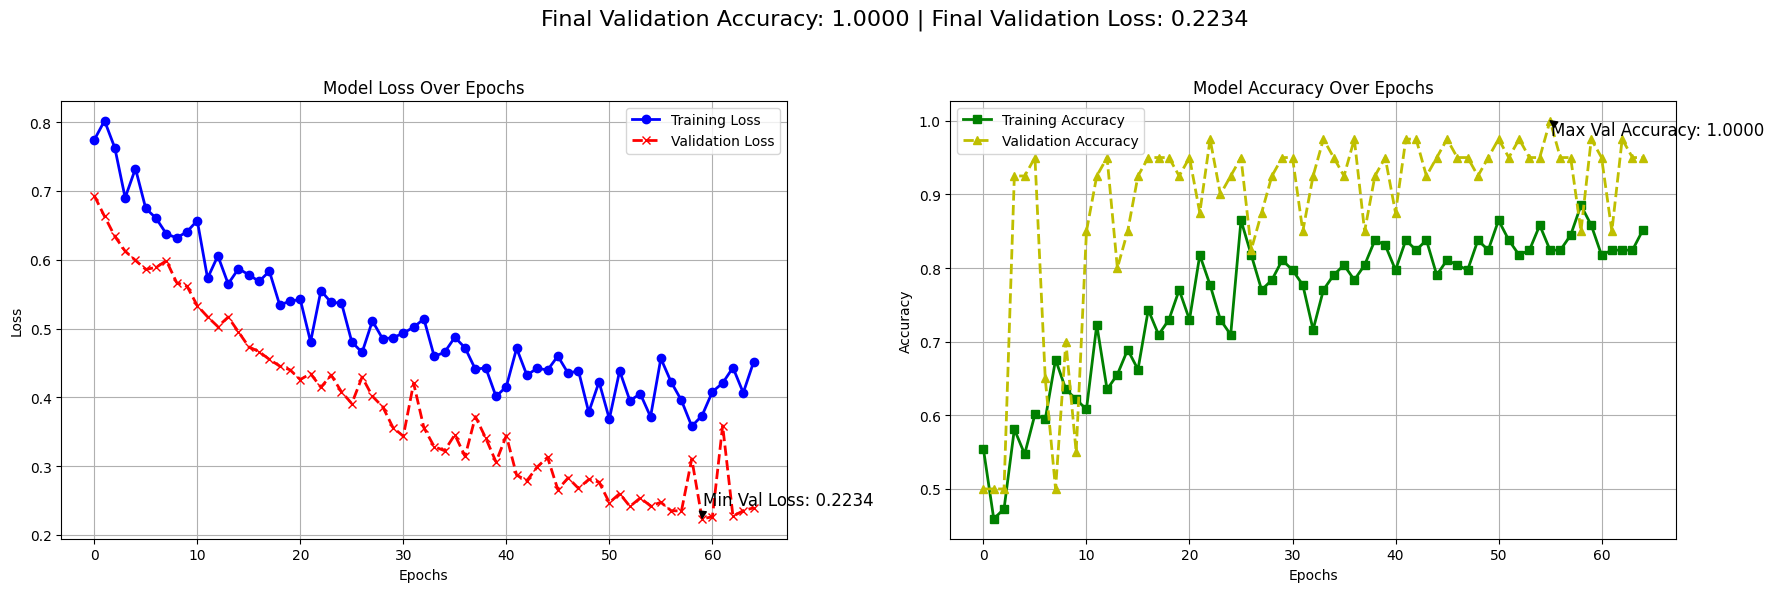

In [21]:
# Plot the training history
plot_training_history(history)

# **Detailed Analysis:**

## 1. **Left Plot: "Model Loss Over Epochs"**
This plot shows the training loss and validation loss over 64 epochs:
- **X-axis** represents the number of epochs.
- **Y-axis** represents the loss value.
- **Blue Line** (Training Loss) shows the loss of the model during training.
- **Red Dashed Line** (Validation Loss) shows the model's loss on the validation set.

**Interpretation:**
- The validation loss decreases steadily and reaches a minimum value (Min Val Loss: 0.2234), indicating that the model's performance on the validation set improved over time.
- There are some fluctuations in the red line (Validation Loss) after the midpoint, indicating that the model's performance on the validation data may be unstable at certain points.

## 2. **Right Plot: "Model Accuracy Over Epochs"**
This plot displays the model's accuracy during training and validation:
- **X-axis** represents the number of epochs.
- **Y-axis** represents accuracy.
- **Green Solid Line** (Training Accuracy) shows the accuracy on the training data.
- **Yellow Dashed Line** (Validation Accuracy) shows the accuracy on the validation data.

**Interpretation:**
- The validation accuracy reaches a perfect score (Max Val Accuracy: 1.0000) in some epochs, indicating that the model made perfect predictions on the validation data at these points.
- However, there are some fluctuations in training accuracy, which might suggest that the model is experiencing instability or potential overfitting.

# **Final Results:**
- **Final Validation Accuracy** is 1.0, indicating that the model achieved perfect accuracy on the validation set at the end of training.
- **Final Validation Loss** is 0.2234, showing that the loss on the validation set is relatively low.

# **Conclusion:**
- **Overall Model Performance:** The model performs well on the validation data, achieving perfect accuracy. However, the fluctuations in loss and accuracy suggest that it might need further tuning to stabilize training and avoid overfitting on the training data.